# **Source: https://www.kaggle.com/code/dariusfoodeei/multiclass-skincancer-torch**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.onnx
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from tqdm import tqdm

In [2]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 100.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation
columns_rearranged = ['image', 'NV', 'MEL', 'BCC', 'AKIEC', 'DF', 'VASC']

skin_cancer_df = pd.read_csv('/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/GroundTruth.csv')
skin_cancer_df.drop(columns=['BKL'], inplace=True)
skin_cancer_df = skin_cancer_df[columns_rearranged]

Using device: cuda


In [35]:
multiclass_categories = {
    0: 'NV',
    1: 'MEL',
    2: 'BCC',
    3: 'AKIEC',
    4: 'DF',
    5: 'VASC'
}

filenames_list, multiclass_categories_list = [], []


base_paths = [
    ("/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images", skin_cancer_df),
]


In [36]:
for base_path, database in base_paths:
    if isinstance(database, pd.DataFrame):
        for row in database.itertuples(index=False):
            filename = os.path.join(base_path, row[0]) + '.jpg'
            filenames_list.append(filename)
            multiclass_index = np.argmax(row[1:])
            multiclass_categories_list.append(multiclass_index)
    else:
        for sub_directory in database[0]:
            for sub_sub_directory in database[1]:
                final_path = os.path.join(base_path, sub_directory, sub_sub_directory)
                for filename in os.listdir(final_path):
                    filenames_list.append(os.path.join(final_path, filename))
                    if sub_sub_directory in ['nevus', 'NotMelanoma']:
                        multiclass_categories_list.append(0)
                    else:
                        multiclass_categories_list.append(database[1].index(sub_sub_directory))

multiclass_df = pd.DataFrame({"filename": filenames_list, "category": multiclass_categories_list})
multiclass_df = multiclass_df.sample(frac=1).reset_index(drop=True)

multiclass_class_counts = np.bincount(multiclass_categories_list)
multiclass_class_weights = {i: len(multiclass_categories_list) / (2.0 * count) for i, count in enumerate(multiclass_class_counts)}

print(f"Multi-class weights: {multiclass_class_weights}")

Multi-class weights: {0: 0.6416581240389544, 1: 4.499101527403414, 2: 9.742217898832685, 3: 15.313455657492355, 4: 43.54347826086956, 5: 35.264084507042256}


<ipython-input-37-a76bd2b1a029>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni, x=uni.index, y='Count', palette='icefire', width=0.4).set_title('Class distribution in Dataset', fontsize=15)


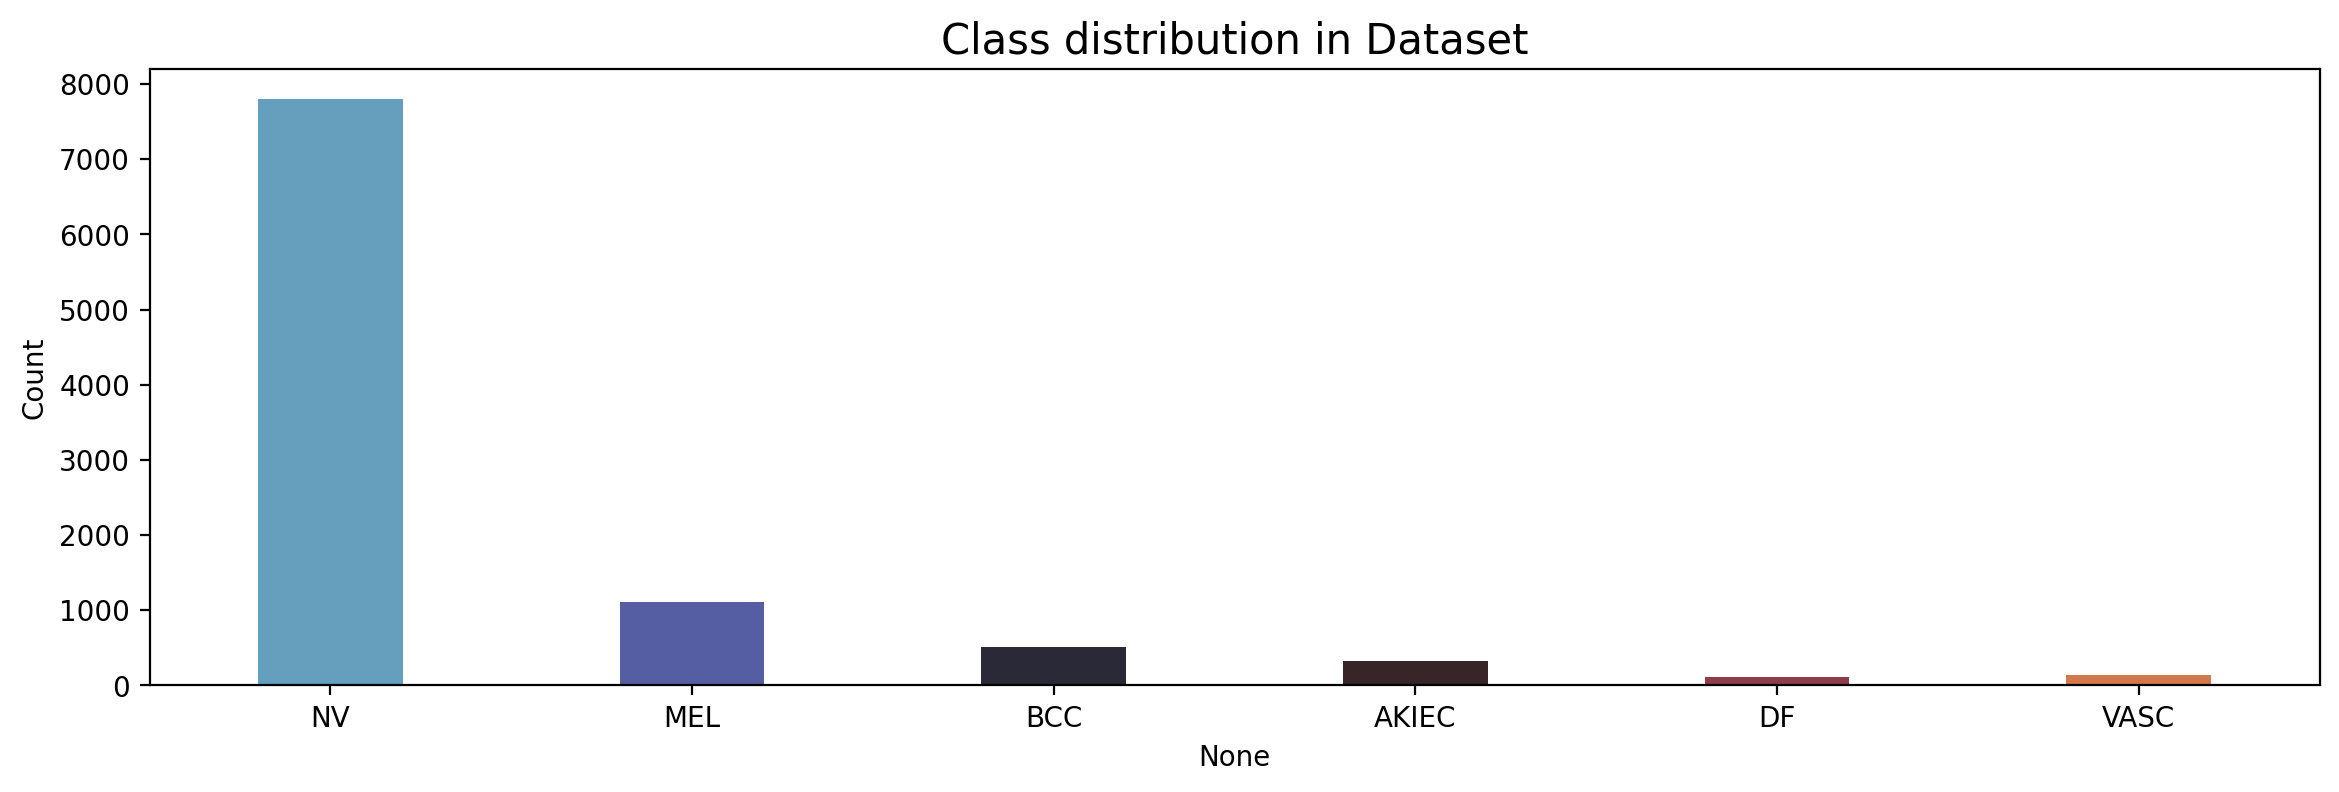

In [37]:
# Visualization
label, count = np.unique(multiclass_df.category, return_counts=True)
uni = pd.DataFrame(data=count, index=multiclass_categories.values(), columns=['Count'])

plt.figure(figsize=(14, 4), dpi=200)
sns.barplot(data=uni, x=uni.index, y='Count', palette='icefire', width=0.4).set_title('Class distribution in Dataset', fontsize=15)
plt.show()

In [10]:
from PIL import Image
import os

dataset_path = "/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images"
valid_images = []

for img_file in os.listdir(dataset_path):
    try:
        img_path = os.path.join(dataset_path, img_file)
        with Image.open(img_path) as img:
            img.verify()  # Verify that the file is intact
        valid_images.append(img_file)
    except Exception as e:
        print(f"Skipping corrupted image: {img_file}, Error: {e}")

Skipping corrupted image: LICENSE.txt, Error: cannot identify image file '/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images/LICENSE.txt'
Skipping corrupted image: ATTRIBUTION.txt, Error: cannot identify image file '/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images/ATTRIBUTION.txt'


In [38]:
# Train-validation-test split
multiclass_train_df, multiclass_temp_df = train_test_split(multiclass_df, test_size=0.2, stratify=multiclass_df['category'], random_state=42)
multiclass_cv_df, multiclass_test_df = train_test_split(multiclass_temp_df, test_size=0.5, stratify=multiclass_temp_df['category'], random_state=42)

In [39]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

image_size = (224, 224)
batch_size = 32

In [40]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = SkinCancerDataset(multiclass_train_df, transform=transform)
val_dataset = SkinCancerDataset(multiclass_cv_df, transform=transform)
test_dataset = SkinCancerDataset(multiclass_test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=14)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=14)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [41]:
class MobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV3, self).__init__()
        self.model = models.mobilenet_v3_small(pretrained=True)
        in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        return x

model = MobileNetV3(num_classes=len(multiclass_categories))
model = model.to(device)

[torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['Tesla T4']

In [42]:
model = MobileNetV3(num_classes=len(multiclass_categories))
model = model.to(device)

# Define the criterion with class weights
class_weights = torch.tensor(list(multiclass_class_weights.values()), dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

num_epochs = 20
early_stopping_patience = 6
best_val_loss = float('inf')
epochs_no_improve = 0

In [ ]:
# This might result in partially loaded images, so proceed with caution !!!!
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train_one_epoch(epoch, model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    correct_train = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", ncols=100):
        images, labels = images.to(device, dtype=torch.float32), labels.cuda().long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / len(train_loader.dataset)

    return train_loss, train_accuracy

def validate_one_epoch(epoch, model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", ncols=100):
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / len(val_loader.dataset)

    return val_loss, val_accuracy

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(epoch, model, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy = validate_one_epoch(epoch, model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping")
            break

train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device)

Training Epoch 1/20:   0%|                                                  | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 1/20: 100%|████████████████████████████████████████| 32/32 [00:13<00:00,  2.37it/s]


Epoch 1/20, Train Loss: 1.4835, Train Accuracy: 0.5997, Validation Loss: 1.4092, Validation Accuracy: 0.6154


Validation Epoch 2/20: 100%|████████████████████████████████████████| 32/32 [00:13<00:00,  2.38it/s]


Epoch 2/20, Train Loss: 1.3723, Train Accuracy: 0.6397, Validation Loss: 1.3630, Validation Accuracy: 0.5734


Validation Epoch 3/20: 100%|████████████████████████████████████████| 32/32 [00:13<00:00,  2.36it/s]


Epoch 3/20, Train Loss: 1.3259, Train Accuracy: 0.6732, Validation Loss: 1.3350, Validation Accuracy: 0.7013


Validation Epoch 4/20: 100%|████████████████████████████████████████| 32/32 [00:15<00:00,  2.03it/s]


Epoch 4/20, Train Loss: 1.3287, Train Accuracy: 0.6900, Validation Loss: 1.3442, Validation Accuracy: 0.6464


Validation Epoch 5/20: 100%|████████████████████████████████████████| 32/32 [00:19<00:00,  1.66it/s]


Epoch 5/20, Train Loss: 1.3083, Train Accuracy: 0.6938, Validation Loss: 1.3564, Validation Accuracy: 0.6583


Validation Epoch 6/20: 100%|████████████████████████████████████████| 32/32 [00:17<00:00,  1.80it/s]


Epoch 6/20, Train Loss: 1.2914, Train Accuracy: 0.7106, Validation Loss: 1.3214, Validation Accuracy: 0.7752


Validation Epoch 7/20: 100%|████████████████████████████████████████| 32/32 [00:15<00:00,  2.00it/s]


Epoch 7/20, Train Loss: 1.2839, Train Accuracy: 0.7158, Validation Loss: 1.3352, Validation Accuracy: 0.6274


Validation Epoch 8/20: 100%|████████████████████████████████████████| 32/32 [00:17<00:00,  1.84it/s]


Epoch 8/20, Train Loss: 1.2566, Train Accuracy: 0.7210, Validation Loss: 1.3096, Validation Accuracy: 0.6813


Validation Epoch 9/20: 100%|████████████████████████████████████████| 32/32 [00:16<00:00,  1.94it/s]


Epoch 9/20, Train Loss: 1.2674, Train Accuracy: 0.7346, Validation Loss: 1.3366, Validation Accuracy: 0.6593


Validation Epoch 10/20: 100%|███████████████████████████████████████| 32/32 [00:19<00:00,  1.61it/s]


Epoch 10/20, Train Loss: 1.2926, Train Accuracy: 0.7228, Validation Loss: 1.3558, Validation Accuracy: 0.7333


Validation Epoch 11/20: 100%|███████████████████████████████████████| 32/32 [00:21<00:00,  1.46it/s]


Epoch 11/20, Train Loss: 1.2605, Train Accuracy: 0.7069, Validation Loss: 1.2981, Validation Accuracy: 0.7752


Validation Epoch 12/20: 100%|███████████████████████████████████████| 32/32 [00:19<00:00,  1.67it/s]


Epoch 12/20, Train Loss: 1.2555, Train Accuracy: 0.7329, Validation Loss: 1.3299, Validation Accuracy: 0.7043


Validation Epoch 13/20: 100%|███████████████████████████████████████| 32/32 [00:19<00:00,  1.67it/s]


Epoch 13/20, Train Loss: 1.2592, Train Accuracy: 0.7294, Validation Loss: 1.3266, Validation Accuracy: 0.6983


Validation Epoch 14/20: 100%|███████████████████████████████████████| 32/32 [00:16<00:00,  1.94it/s]


Epoch 14/20, Train Loss: 1.2407, Train Accuracy: 0.7408, Validation Loss: 1.2761, Validation Accuracy: 0.7303


Validation Epoch 15/20: 100%|███████████████████████████████████████| 32/32 [00:17<00:00,  1.86it/s]


Epoch 15/20, Train Loss: 1.2481, Train Accuracy: 0.7471, Validation Loss: 1.2500, Validation Accuracy: 0.7283


Validation Epoch 16/20: 100%|███████████████████████████████████████| 32/32 [00:21<00:00,  1.50it/s]


Epoch 16/20, Train Loss: 1.2396, Train Accuracy: 0.7302, Validation Loss: 1.3505, Validation Accuracy: 0.6434


Validation Epoch 17/20: 100%|███████████████████████████████████████| 32/32 [00:16<00:00,  1.89it/s]


Epoch 17/20, Train Loss: 1.2406, Train Accuracy: 0.7509, Validation Loss: 1.3319, Validation Accuracy: 0.7093


Validation Epoch 18/20: 100%|███████████████████████████████████████| 32/32 [00:14<00:00,  2.26it/s]


Epoch 18/20, Train Loss: 1.2316, Train Accuracy: 0.7483, Validation Loss: 1.2785, Validation Accuracy: 0.7552


Validation Epoch 19/20: 100%|███████████████████████████████████████| 32/32 [00:20<00:00,  1.60it/s]


Epoch 19/20, Train Loss: 1.2030, Train Accuracy: 0.7656, Validation Loss: 1.2283, Validation Accuracy: 0.7393


Validation Epoch 20/20: 100%|███████████████████████████████████████| 32/32 [00:19<00:00,  1.68it/s]

Epoch 20/20, Train Loss: 1.1869, Train Accuracy: 0.7752, Validation Loss: 1.2624, Validation Accuracy: 0.7712


In [ ]:
# Test the model
model.eval()
test_loss = 0.0
correct_test = 0

# Create a dummy input tensor matching the input dimensions of the model
dummy_input = torch.randn(1, 3, 224, 224, device='cuda')  # Example for a model with 3-channel image input

# Export the model
torch.onnx.export(model, dummy_input, "model.onnx", export_params=True, opset_version=10)

predictions = []
true_classes = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", ncols=100):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_classes.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct_test / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Testing: 100%|██████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s]

Test Loss: 1.2410
Test Accuracy: 75.75%


In [ ]:
# Calculate precision
precision = accuracy_score(true_classes, predictions) * 100
print(f'Precision: {precision:.2f}%')

Precision: 75.75%


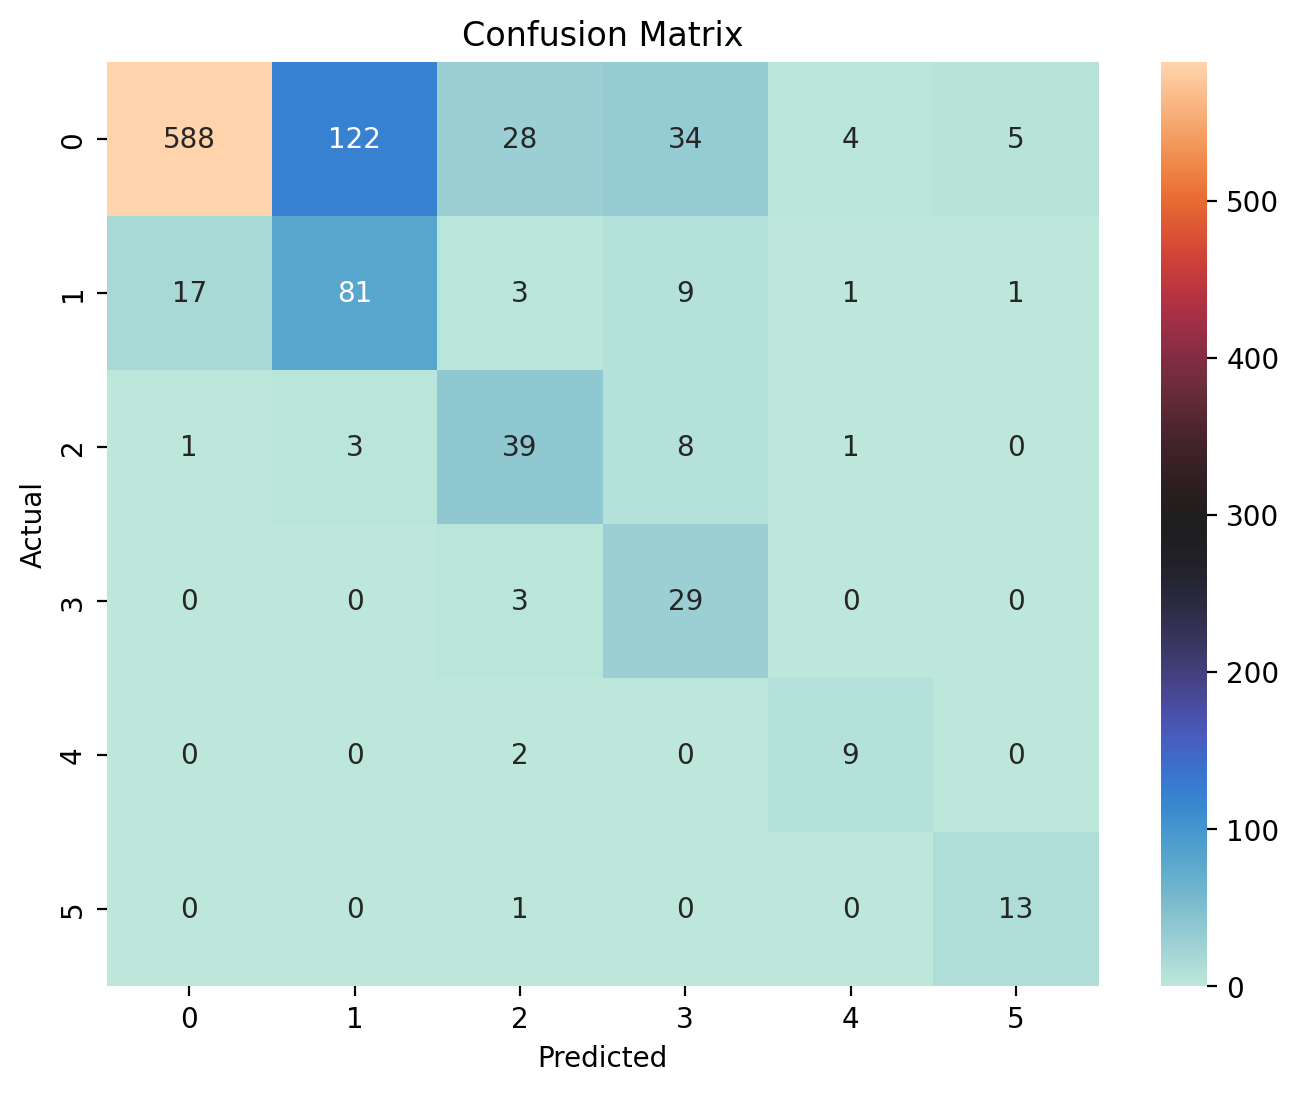

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predictions)
plt.figure(figsize=(8, 6), dpi=200)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='icefire', xticklabels=multiclass_categories.keys(), yticklabels=multiclass_categories.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
# Save the model
torch.save(model.state_dict(), 'multiclass_model_final.pth')

# Load an image-label pair from the test dataset
image, label = test_dataset.__getitem__(0)
print(image)

# Ensure the model is in evaluation mode
model.eval()

# If you're using a GPU, you also need to send the image and the model to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
image = image.to(device)  # Send the image to the GPU if you're using one

# Perform the forward pass with no_grad to save memory and compute speed
with torch.no_grad():
    output = model(image.unsqueeze(0))  # Add a batch dimension

# Print the output
print("output: ", output)

# To get the predicted class
predicted_class = torch.argmax(output)
print(f"Predicted class: {predicted_class}")

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

# **XAI Approaches**

In [16]:
# Load the best model (PyTorch format)
import torch

model = MobileNetV3(num_classes=len(multiclass_categories))
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

<ipython-input-16-a39ca1e65d6a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cuda' if torch

MobileNetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2d

In [17]:
# Inspect the model architecture
print(model)

MobileNetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2d

## **Visualize class prediction probabilities**

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


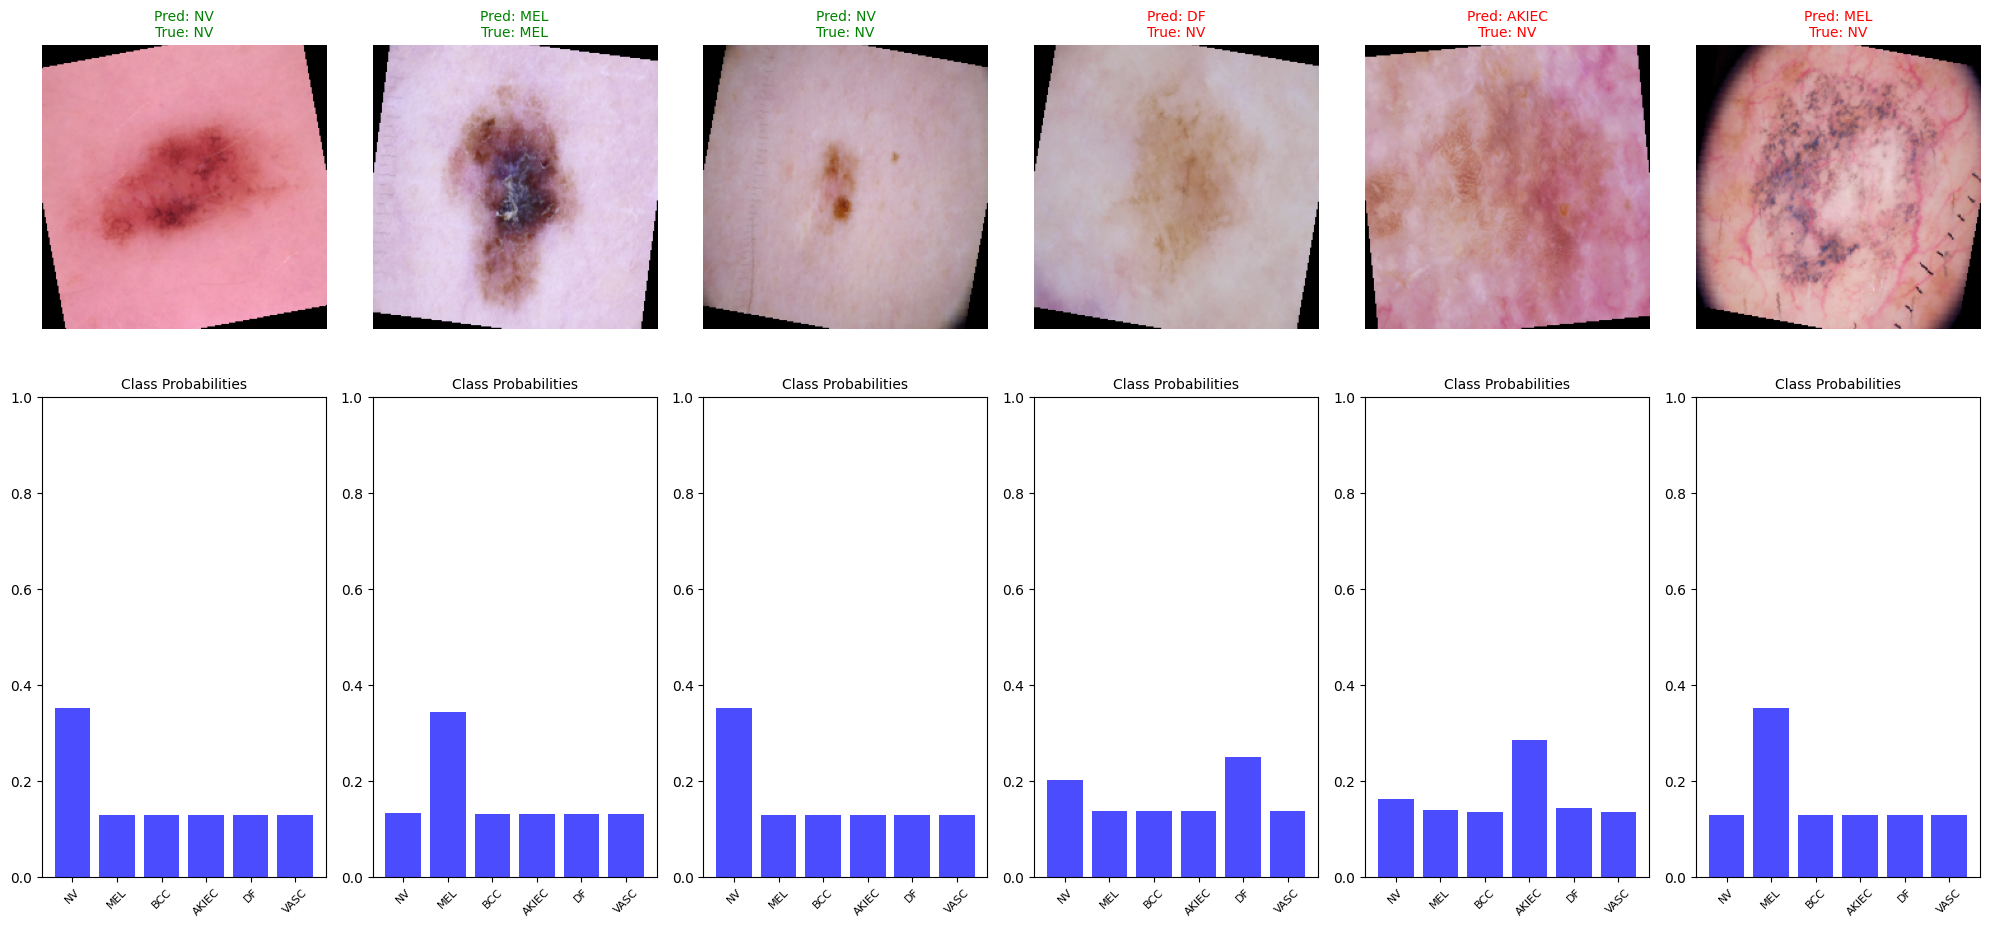

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define function to visualize classified images with all class scores
def plot_classified_images_with_scores(model, dataloader, class_names, device, num_images=6):
    """
    Plot correctly and incorrectly classified images with their probabilities for all classes.

    Args:
    - model: Trained PyTorch model.
    - dataloader: DataLoader for the test dataset.
    - class_names: List of class names.
    - device: Computation device ('cuda' or 'cpu').
    - num_images: Number of images to plot (default: 6).
    """
    model.eval()
    all_images = []
    all_labels = []
    all_predictions = []
    all_probs = []

    # Collect predictions, true labels, and probabilities
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_images.append(images.cpu())
            all_labels.append(labels.cpu())
            all_predictions.append(preds.cpu())
            all_probs.append(probs.cpu())

    # Flatten lists
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)
    all_probs = torch.cat(all_probs, dim=0)

    # Identify correct and incorrect indices
    correct_indices = (all_predictions == all_labels).nonzero(as_tuple=True)[0]
    incorrect_indices = (all_predictions != all_labels).nonzero(as_tuple=True)[0]

    # Select random correct and incorrect samples
    correct_sample_indices = np.random.choice(correct_indices, num_images // 2, replace=False)
    incorrect_sample_indices = np.random.choice(incorrect_indices, num_images // 2, replace=False)
    selected_indices = np.concatenate([correct_sample_indices, incorrect_sample_indices])

    # Plot the images
    fig, axes = plt.subplots(2, num_images, figsize=(20, 10))  # Two rows: images and bar plots
    for i, idx in enumerate(selected_indices):
        image = all_images[idx].permute(1, 2, 0).numpy()  # Convert to HWC format
        image = np.clip(image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)  # Denormalize
        true_label = class_names[all_labels[idx]]
        pred_label = class_names[all_predictions[idx]]
        pred_probs = all_probs[idx].numpy()

        # Image Plot
        ax_image = axes[0, i]
        ax_image.imshow(image)
        ax_image.axis('off')
        ax_image.set_title(
            f"Pred: {pred_label}\nTrue: {true_label}",
            color=("green" if all_predictions[idx] == all_labels[idx] else "red"),
            fontsize=10
        )

        # Bar Plot for Probabilities
        ax_bar = axes[1, i]
        ax_bar.bar(class_names, pred_probs, color='blue', alpha=0.7)
        ax_bar.set_ylim([0, 1])
        ax_bar.set_xticks(range(len(class_names)))
        ax_bar.set_xticklabels(class_names, rotation=45, fontsize=8)
        ax_bar.set_title("Class Probabilities", fontsize=10)

    plt.tight_layout()
    plt.show()


class_names = list(multiclass_categories.values())
plot_classified_images_with_scores(model, test_loader, class_names, device)

# **Grad-Cam**

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


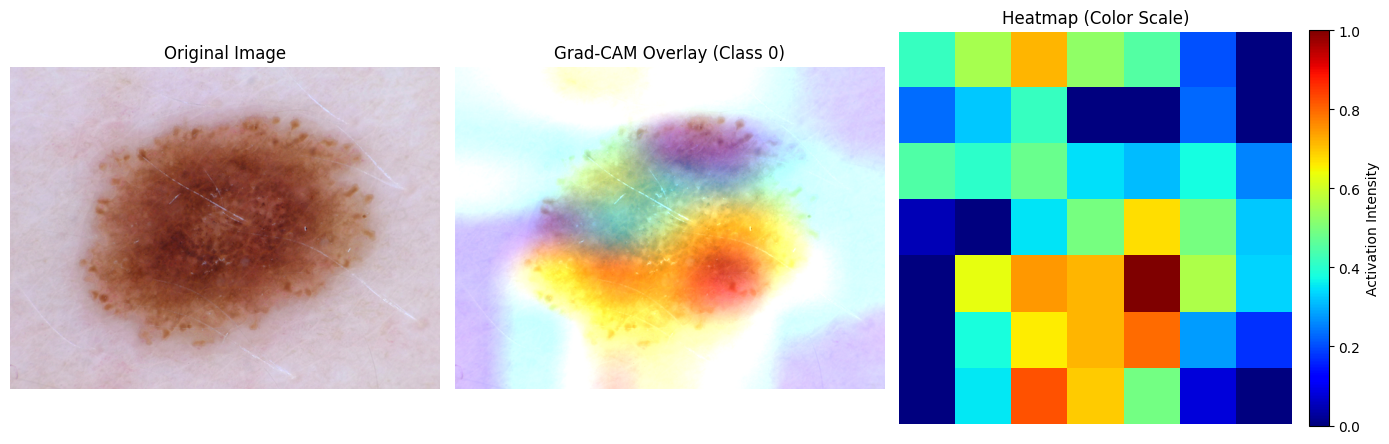

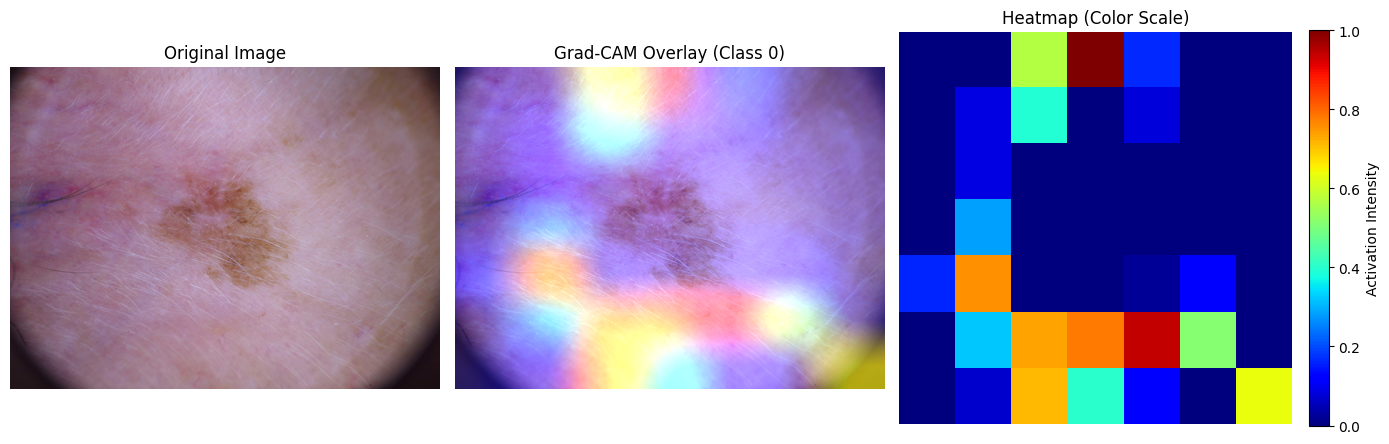

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from PIL import Image

def preprocess_image(img_path, transform):
    """Load and preprocess an image for the model."""
    image = Image.open(img_path).convert("RGB")
    return transform(image).unsqueeze(0)

def generate_gradcam_heatmap(model, img_tensor, target_class, last_conv_layer_name):
    """Generate Grad-CAM heatmap."""
    # Ensure model is in evaluation mode
    model.eval()

    # Hook to capture gradients
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks to the specified layer
    last_conv_layer = dict(model.named_modules())[last_conv_layer_name]
    last_conv_layer.register_forward_hook(forward_hook)
    last_conv_layer.register_backward_hook(backward_hook)

    # Forward pass
    img_tensor = img_tensor.to(device)
    outputs = model(img_tensor)
    target_score = outputs[0, target_class]

    # Backward pass to compute gradients of the target class
    model.zero_grad()
    target_score.backward(retain_graph=True)

    # Extract gradients and activations
    grads = gradients[0].cpu().data.numpy()
    acts = activations[0].cpu().data.numpy()

    # Compute importance weights
    weights = np.mean(grads, axis=(2, 3))  # Global average pooling
    heatmap = np.sum(weights[:, :, np.newaxis, np.newaxis] * acts, axis=1).squeeze()

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max() if heatmap.max() != 0 else 1

    return heatmap

def overlay_gradcam_heatmap(heatmap, original_image, alpha=0.6, colormap='jet'):
    """Overlay Grad-CAM heatmap on the original image."""
    heatmap = np.uint8(255 * heatmap)
    colormap = plt.get_cmap(colormap)
    colored_heatmap = colormap(heatmap)
    colored_heatmap = np.delete(colored_heatmap, 3, axis=2)  # Remove alpha channel

    # Resize heatmap to original image dimensions
    colored_heatmap = Image.fromarray((colored_heatmap * 255).astype("uint8")).resize(original_image.size, Image.LANCZOS)
    colored_heatmap = np.array(colored_heatmap) / 255.0  # Normalize to [0, 1]

    # Superimpose the heatmap onto the original image
    original_image = np.array(original_image) / 255.0
    superimposed_image = colored_heatmap * alpha + original_image
    superimposed_image = np.clip(superimposed_image, 0, 1)
    return (superimposed_image * 255).astype("uint8")

# EASY IMAGE
# Load and preprocess the image
image_path = "/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images/ISIC_0024317.jpg"  # ISIC_0024624.jpg
original_image = Image.open(image_path).convert("RGB")
img_tensor = preprocess_image(image_path, transform)

# Generate Grad-CAM heatmap
target_class = 0  # Update to the desired class index
last_conv_layer_name = "model.features.11.block"
heatmap = generate_gradcam_heatmap(model, img_tensor, target_class, last_conv_layer_name)

# Overlay Grad-CAM heatmap on the original image
superimposed_image = overlay_gradcam_heatmap(heatmap, original_image, alpha=0.6)

# Display the results
plt.figure(figsize=(14, 7))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Grad-CAM Overlay
plt.subplot(1, 3, 2)
plt.imshow(superimposed_image)
plt.title(f"Grad-CAM Overlay (Class {target_class})")
plt.axis("off")

# Heatmap with Colorbar
plt.subplot(1, 3, 3)
plt.imshow(heatmap, cmap="jet")
plt.title("Heatmap (Color Scale)")
plt.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="jet"), ax=plt.gca(), fraction=0.046, pad=0.04)
cbar.set_label("Activation Intensity")

plt.tight_layout()
plt.show()

# CHALLENGING IMAGE
image_path_2 = "/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images/ISIC_0024624.jpg"
original_image = Image.open(image_path_2).convert("RGB")
img_tensor = preprocess_image(image_path_2, transform)

# Generate Grad-CAM heatmap
target_class = 0  # Update to the desired class index
last_conv_layer_name = "model.features.11.block"
heatmap = generate_gradcam_heatmap(model, img_tensor, target_class, last_conv_layer_name)

# Overlay Grad-CAM heatmap on the original image
superimposed_image = overlay_gradcam_heatmap(heatmap, original_image, alpha=0.6)

# Display the results
plt.figure(figsize=(14, 7))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Grad-CAM Overlay
plt.subplot(1, 3, 2)
plt.imshow(superimposed_image)
plt.title(f"Grad-CAM Overlay (Class {target_class})")
plt.axis("off")

# Heatmap with Colorbar
plt.subplot(1, 3, 3)
plt.imshow(heatmap, cmap="jet")
plt.title("Heatmap (Color Scale)")
plt.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="jet"), ax=plt.gca(), fraction=0.046, pad=0.04)
cbar.set_label("Activation Intensity")

plt.tight_layout()
plt.show()

# **LIME**

In [43]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=399e6751e781a5fb8fdf96cc3bb5d549f87076df5da58f61ee4782788cf7a101
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

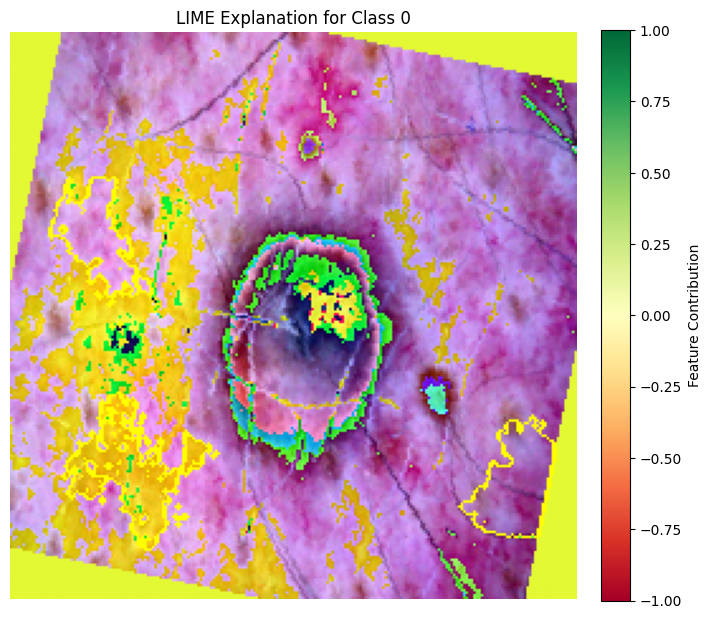

In [44]:
# LIME WITH LEGEND
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

# Predict function for LIME
def predict_fn(images):
    images = torch.stack([transform(transforms.ToPILImage()(img)) for img in images])
    images = images.to(device)
    outputs = model(images)
    return outputs.cpu().detach().numpy()

# Test LIME on a single image
image, label = test_dataset.__getitem__(0)
image_np = np.array(transforms.ToPILImage()(image))

# Generate explanation
explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    labels=[label],
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the specific class label
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,  # Only show positive contributions
    num_features=3,  # Number of features (segments) to show
    hide_rest=False
)

# Visualize the explanation using `mark_boundaries` to overlay the mask on the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(mark_boundaries(temp, mask))

# Title
ax.set_title(f'LIME Explanation for Class {label}')
ax.axis('off')

# Create a colorbar to show positive and negative contributions
import matplotlib as mpl
cmap = mpl.cm.RdYlGn  # Red-Yellow-Green color map, with red for negative and green for positive
norm = mpl.colors.Normalize(vmin=-1, vmax=1)  # Normalize the color scale

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Create a dummy array for the color bar
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Feature Contribution')

# Display the plot
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

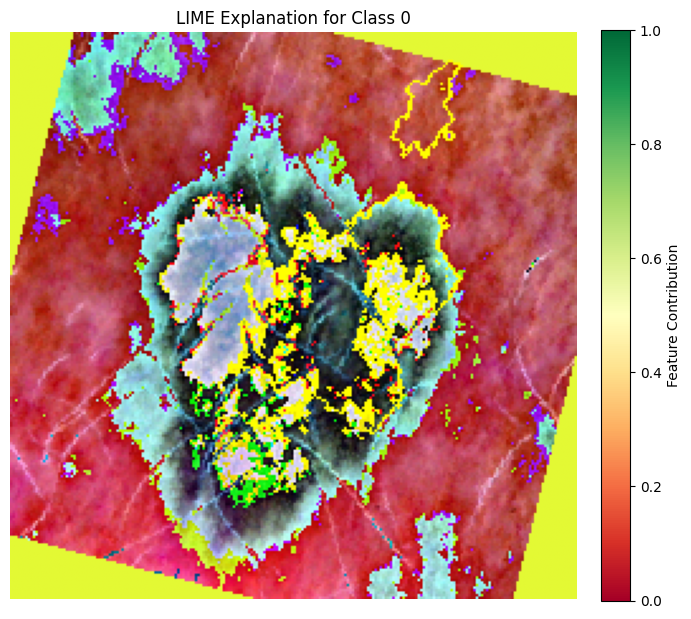

In [46]:
# !!!!!!!!!!!!!!!!!!!!
# CONCLUSION/INSIGHT: CLASSIFICATION RELIES ON LESION TEXTURE AND SURROUNDING IRREGULARITIES
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib as mpl

# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

# Predict function for LIME
def predict_fn(images):
    images = torch.stack([transform(transforms.ToPILImage()(img)) for img in images])
    images = images.to(device)
    outputs = model(images)
    return outputs.cpu().detach().numpy()

# Test LIME on a single image
image, label = test_dataset.__getitem__(123)
image_np = np.array(transforms.ToPILImage()(image))

# Generate explanation
explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    labels=[label],
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the specific class label
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,  # Only show positive contributions
    num_features=3,  # Number of features (segments) to show
    hide_rest=False
)

# Clip the mask to ensure it is within the expected range [0, 1] before applying the colormap
# mask = np.clip(mask, 0, 1)

# Visualize the explanation using `mark_boundaries` to overlay the mask on the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(mark_boundaries(temp, mask))

# Title
ax.set_title(f'LIME Explanation for Class {label}')
ax.axis('off')

# Create a colorbar to show positive and negative contributions
cmap = mpl.cm.RdYlGn  # Red-Yellow-Green color map, with red for negative and green for positive
# norm = mpl.colors.Normalize(vmin=0, vmax=1)  # Normalize the color scale to [0, 1]

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])  # Create a dummy array for the color bar
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Feature Contribution')

# Display the plot
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

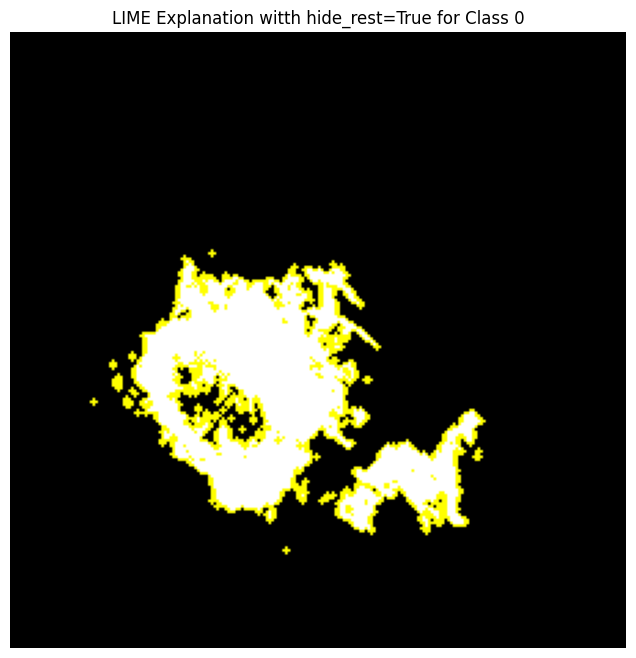

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib as mpl

# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

# Predict function for LIME
def predict_fn(images):
    images = torch.stack([transform(transforms.ToPILImage()(img)) for img in images])
    images = images.to(device)
    outputs = model(images)
    return outputs.cpu().detach().numpy()

# Test LIME on a single image
image, label = test_dataset.__getitem__(123)
image_np = np.array(transforms.ToPILImage()(image))

# Generate explanation
explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    labels=[label],
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the specific class label
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,  # Only show positive contributions
    num_features=3,  # Number of features (segments) to show
    hide_rest=True
)

# Clip the mask to ensure it is within the expected range [0, 1] before applying the colormap
# mask = np.clip(mask, 0, 1)

# Visualize the explanation using `mark_boundaries` to overlay the mask on the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(mark_boundaries(temp, mask))

# Title
ax.set_title(f'LIME Explanation witth hide_rest=True for Class {label}')
ax.axis('off')

# Display the plot
plt.show()